## Predicting Survival on the Titanic

### History
Perhaps one of the most infamous shipwrecks in history, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 people on board. Interestingly, by analysing the probability of survival based on few attributes like gender, age, and social status, we can make very accurate predictions on which passengers would survive. Some groups of people were more likely to survive than others, such as women, children, and the upper-class. Therefore, we can learn about the society priorities and privileges at the time.

### Assignment:

Build a Machine Learning Pipeline, to engineer the features in the data set and predict who is more likely to Survive the catastrophe.

Follow the Jupyter notebook below, and complete the missing bits of code, to achieve each one of the pipeline steps.

In [118]:
import re

# to handle datasets
import pandas as pd
import numpy as np

# for visualization
import matplotlib.pyplot as plt

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score

# to persist the model and the scaler
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

## Prepare the data set

In [147]:
# load the data - it is available open source and online

data = pd.read_csv('https://www.openml.org/data/get_csv/16826755/phpMYEkMl')

# display data
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [148]:
# replace interrogation marks by NaN values

data = data.replace('?', np.nan)

In [149]:
# retain only the first cabin if more than
# 1 are available per passenger

def get_first_cabin(row):
    try:
        return row.split()[0]
    except:
        return np.nan
    
data['cabin'] = data['cabin'].apply(get_first_cabin)

In [150]:
# extracts the title (Mr, Ms, etc) from the name variable

def get_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'
    
data['title'] = data['name'].apply(get_title)

In [151]:
# cast numerical variables as floats

data['fare'] = data['fare'].astype('float')
data['age'] = data['age'].astype('float')

In [152]:
# drop unnecessary variables

data.drop(labels=['name','ticket', 'boat', 'body','home.dest'], axis=1, inplace=True)

# display data
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,title
0,1,1,female,29.0000,0,0,211.3375,B5,S,Miss
1,1,1,male,0.9167,1,2,151.5500,C22,S,Master
2,1,0,female,2.0000,1,2,151.5500,C22,S,Miss
3,1,0,male,30.0000,1,2,151.5500,C22,S,Mr
4,1,0,female,25.0000,1,2,151.5500,C22,S,Mrs


In [153]:
# save the data set

data.to_csv('titanic.csv', index=False)

## Data Exploration

### Find numerical and categorical variables

In [154]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
pclass      1309 non-null int64
survived    1309 non-null int64
sex         1309 non-null object
age         1046 non-null float64
sibsp       1309 non-null int64
parch       1309 non-null int64
fare        1308 non-null float64
cabin       295 non-null object
embarked    1307 non-null object
title       1309 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 102.3+ KB


In [155]:
target = 'survived'

In [156]:
vars_cat = [var for var in data.columns if data[var].dtype == 'O']
vars_num = [var for var in data.columns if var not in vars_cat and var != 'survived']

print('Number of numerical variables: {}'.format(len(vars_num)))
print('Number of categorical variables: {}'.format(len(vars_cat)))

Number of numerical variables: 5
Number of categorical variables: 4


### Find missing values in variables

In [157]:
# first in numerical variables
vars_with_na = [var for var in vars_num if data[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

data[vars_with_na].isnull().mean().sort_values(ascending=False)

age     0.200917
fare    0.000764
dtype: float64

In [158]:
# now in categorical variables vars_num
vars_with_na = [var for var in vars_cat if data[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

data[vars_with_na].isnull().mean().sort_values(ascending=False)


cabin       0.774637
embarked    0.001528
dtype: float64

### Determine cardinality of categorical variables

In [159]:
len(data['cabin'].value_counts())

181

In [160]:
len(data['embarked'].value_counts())

3

### Determine the distribution of numerical variables

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [162]:
def dfdisplot(df, cols, rowSize=3, colSize=3, nCol=3):
    if len(cols) % nCol == 0:
        nRow= len(cols)// nCol
    else:
        nRow= len(cols)// nCol + 1
    fig,axes = plt.subplots(nRow,nCol,figsize=(nCol*colSize, nRow*rowSize))
    axes = axes.flatten()
    for i, var_name in enumerate(cols):
        g = sns.distplot(df[var_name],ax= axes[i]);
     
    fig.tight_layout()
    fig.show()

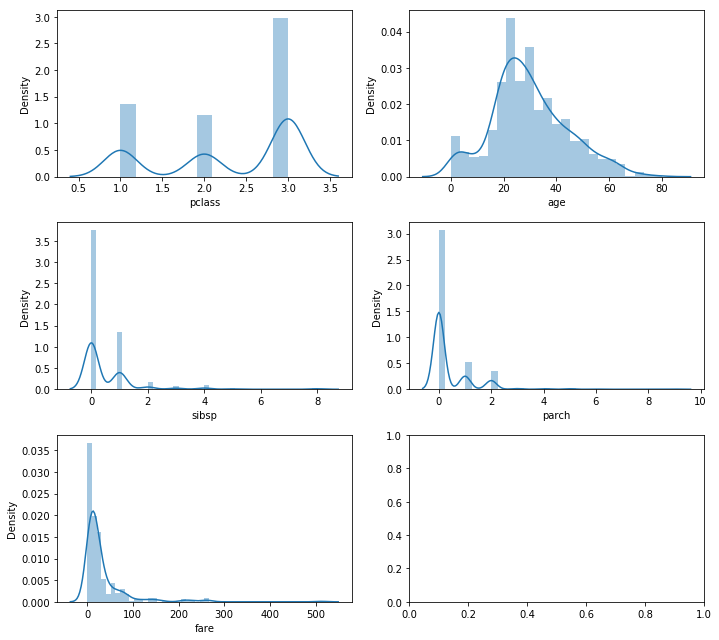

In [163]:
dfdisplot(data, vars_num,3,5,2)

## Feature Engineering

### Extract only the letter (and drop the number) from the variable Cabin

In [164]:
def extra_letter_and_clean(cabin):
    try:
        return re.sub('[^a-zA-Z]+', '', cabin)
    except:
        return 'not_available'
    
data['cabin']=data['cabin'].apply(lambda x: extra_letter_and_clean(x))

In [165]:
data['cabin'].isnull().sum()

0

In [166]:
data['cabin'].value_counts()

not_available    1014
C                  94
B                  65
D                  46
E                  41
A                  22
F                  21
G                   5
T                   1
Name: cabin, dtype: int64

### Fill in Missing data in numerical variables:

- Add a binary missing indicator
- Fill NA in original variable with the median

In [167]:
data = data.fillna(data.median())

In [168]:
data.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
fare        0
cabin       0
embarked    2
title       0
dtype: int64

### Replace Missing data in categorical variables with the string **Missing**

In [169]:
data.embarked = data.embarked.fillna('not_available')

### Remove rare labels in categorical variables

- remove labels present in less than 5 % of the passengers

In [170]:
def find_frequent_labels(df, var, rare_perc):
    
    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index

In [171]:
for var in vars_cat:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(data, var, 0.01)
    
    print(var, frequent_ls)
    print()
    
    # replace rare categories by the string "Rare"
    data[var] = np.where(data[var].isin(
        frequent_ls), data[var], 'Rare')

sex Index(['female', 'male'], dtype='object', name='sex')

cabin Index(['A', 'B', 'C', 'D', 'E', 'F', 'not_available'], dtype='object', name='cabin')

embarked Index(['C', 'Q', 'S'], dtype='object', name='embarked')

title Index(['Master', 'Miss', 'Mr', 'Mrs', 'Other'], dtype='object', name='title')



### Perform one hot encoding of categorical variables into k-1 binary variables

- k-1, means that if the variable contains 9 different categories, we create 8 different binary variables
- Remember to drop the original categorical variable (the one with the strings) after the encoding

In [172]:
for var in vars_cat:
    
    # to create the binary variables, we use get_dummies from pandas
    
    data = pd.concat([data,
                         pd.get_dummies(data[var], prefix=var, drop_first=True)
                         ], axis=1)

data.drop(labels=vars_cat, axis=1, inplace=True)
data.shape

(1309, 21)

## Separate data into train and test

Use the code below for reproducibility. Don't change it.

In [205]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.2,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1047, 20), (262, 20))

### Scale the variables

- Use the standard scaler from Scikit-learn

In [206]:
from sklearn.preprocessing import MinMaxScaler
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train) 

# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

In [207]:
X_train.head()

,pclass,age,sibsp,parch,fare,sex_male,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_Rare,cabin_not_available,embarked_Q,embarked_Rare,embarked_S,title_Miss,title_Mr,title_Mrs,title_Other
0,1.0,0.336343,0.000,0.0,0.015469,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.553047,0.000,0.0,0.262527,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.376975,0.000,0.0,0.015094,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.241535,0.000,0.0,0.015176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.5,0.390519,0.125,0.0,0.040989,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Train the Logistic Regression model

- Set the regularization parameter to 0.0005
- Set the seed to 0

In [208]:
model = LogisticRegression(C=0.0005, random_state=0)

# train the model
model.fit(X_train, y_train)

LogisticRegression(C=0.0005, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Make predictions and evaluate model performance

Determine:
- roc-auc
- accuracy

**Important, remember that to determine the accuracy, you need the outcome 0, 1, referring to survived or not. But to determine the roc-auc you need the probability of survival.**

In [209]:
# make predictions for test set
class_ = model.predict(X_train)
pred = model.predict_proba(X_train)[:,1]

# determine mse and rmse
print('train roc-auc: {}'.format(roc_auc_score(y_train, pred)))
print('train accuracy: {}'.format(accuracy_score(y_train, class_)))
print()

# make predictions for test set
class_ = model.predict(X_test)
pred = model.predict_proba(X_test)[:,1]

# determine mse and rmse
print('test roc-auc: {}'.format(roc_auc_score(y_test, pred)))
print('test accuracy: {}'.format(accuracy_score(y_test, class_)))
print()

train roc-auc: 0.84375
train accuracy: 0.6179560649474689

test roc-auc: 0.8487345679012346
test accuracy: 0.6183206106870229



That's it! Well done

**Keep this code safe, as we will use this notebook later on, to build production code, in our next assignement!!**

## Extra - Pycaret

In [180]:
data.head()

,pclass,survived,age,sibsp,parch,fare,sex_male,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_Rare,cabin_not_available,embarked_Q,embarked_Rare,embarked_S,title_Miss,title_Mr,title_Mrs,title_Other
0,1,1,29.0000,0,0,211.3375,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0
1,1,1,0.9167,1,2,151.5500,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,2.0000,1,2,151.5500,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0
3,1,0,30.0000,1,2,151.5500,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0
4,1,0,25.0000,1,2,151.5500,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [200]:
feature_cols = list(data.columns)
feature_cols.remove('survived')

In [201]:
feature_cols

['pclass',
 'age',
 'sibsp',
 'parch',
 'fare',
 'sex_male',
 'cabin_B',
 'cabin_C',
 'cabin_D',
 'cabin_E',
 'cabin_F',
 'cabin_Rare',
 'cabin_not_available',
 'embarked_Q',
 'embarked_Rare',
 'embarked_S',
 'title_Miss',
 'title_Mr',
 'title_Mrs',
 'title_Other']

In [179]:
from pycaret.classification import *

In [202]:
classification_setup = setup(data, target = 'survived'
                             #,fix_imbalance = True 
                             #,fix_imbalance_method = 'SMOTE' (default)
                             #,remove_outliers = True
                             ,numeric_features = feature_cols
                             #,categorical_features = ['local_time_join_hour']
                             #,outliers_threshold = 0.05
                             #,remove_multicollinearity = True
                             ,normalize = True
                             #,test_data = test
                             #,feature_selection = True
                             ,session_id=123)

,Description,Value
0,session_id,123
1,Target,survived
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1309, 21)"
5,Missing Values,False
6,Numeric Features,20
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [204]:
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8067,0.8609,0.701,0.7767,0.734,0.5832,0.5878,0.018
lda,Linear Discriminant Analysis,0.8056,0.8459,0.738,0.7527,0.7441,0.5876,0.5889,0.053
ridge,Ridge Classifier,0.8035,0,0.738,0.7482,0.742,0.5834,0.5846,0.017
lr,Logistic Regression,0.7959,0.8466,0.7379,0.7331,0.7345,0.5687,0.5698,0.329
lightgbm,Light Gradient Boosting Machine,0.7936,0.8552,0.7095,0.7434,0.7244,0.5598,0.5618,0.015
ada,Ada Boost Classifier,0.787,0.8412,0.7208,0.7246,0.7215,0.5492,0.5504,0.017
rf,Random Forest Classifier,0.7783,0.8419,0.701,0.7145,0.7068,0.5288,0.5297,0.1
knn,K Neighbors Classifier,0.7772,0.8143,0.6695,0.7323,0.6979,0.522,0.5248,0.16
dt,Decision Tree Classifier,0.7729,0.7589,0.6667,0.7215,0.6908,0.5122,0.5149,0.004
et,Extra Trees Classifier,0.7697,0.8094,0.6754,0.7089,0.6909,0.5078,0.5089,0.098


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)